####Importing Libraries

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import operator
from sklearn.model_selection import train_test_split 
from sklearn import datasets, linear_model, metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
import csv
from sklearn import neighbors
import random

####Reading and exploring data

              year  agricultural_land_area  \
count  1401.000000            1.385000e+03   
mean   2007.392577            3.539588e+05   
std       4.595501            1.172377e+06   
min    2000.000000            2.944179e+00   
25%    2003.000000            1.174577e+04   
50%    2007.000000            4.701980e+04   
75%    2011.000000            2.247874e+05   
max    2015.000000            1.045780e+07   

       percentage_of_arable_land_equipped_for_irrigation  cereal_yield  \
count                                        1153.000000   1337.000000   
mean                                           27.891446   2753.178229   
std                                            28.577625   2777.815145   
min                                             0.000000    179.258873   
25%                                             3.490956   1424.503830   
50%                                            18.846225   2221.920986   
75%                                            41.954776   3296.467

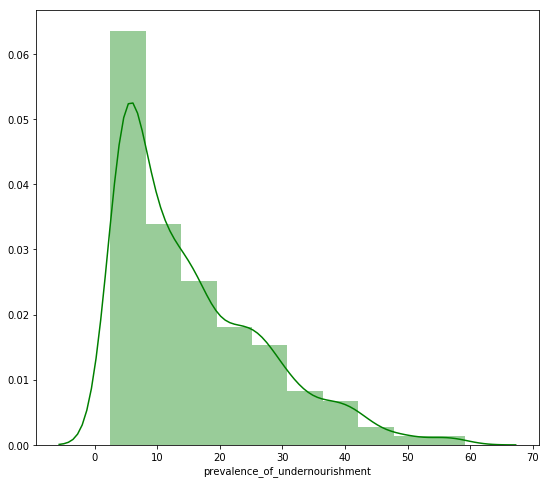

In [2]:
train_var = pd.read_csv('C:/Users/shrut/OneDrive/Documents/Capstone Project/train_values_6tLXv3T.csv') #reading the dataset
train_val = pd.read_csv('C:/Users/shrut/OneDrive/Documents/Capstone Project/train_labels.csv')
train_dat = pd.merge(train_var, train_val, on='row_id')
train_dat = train_dat.drop('row_id', axis=1)
desc_stats = train_dat.describe()
print(desc_stats)
plt.figure(figsize=(9, 8))
sns.distplot(train_dat['prevalence_of_undernourishment'], color='g', bins=10, hist_kws={'alpha': 0.4})

With this information we can see that prevalence of undernourishment is skewed right. We could not see any outliners, but still we would like to do some data manipulation to get a normal distribution of prevalence of undernourishment.

####Distribution of numerical data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029182A370B8>,
      dtype=object)

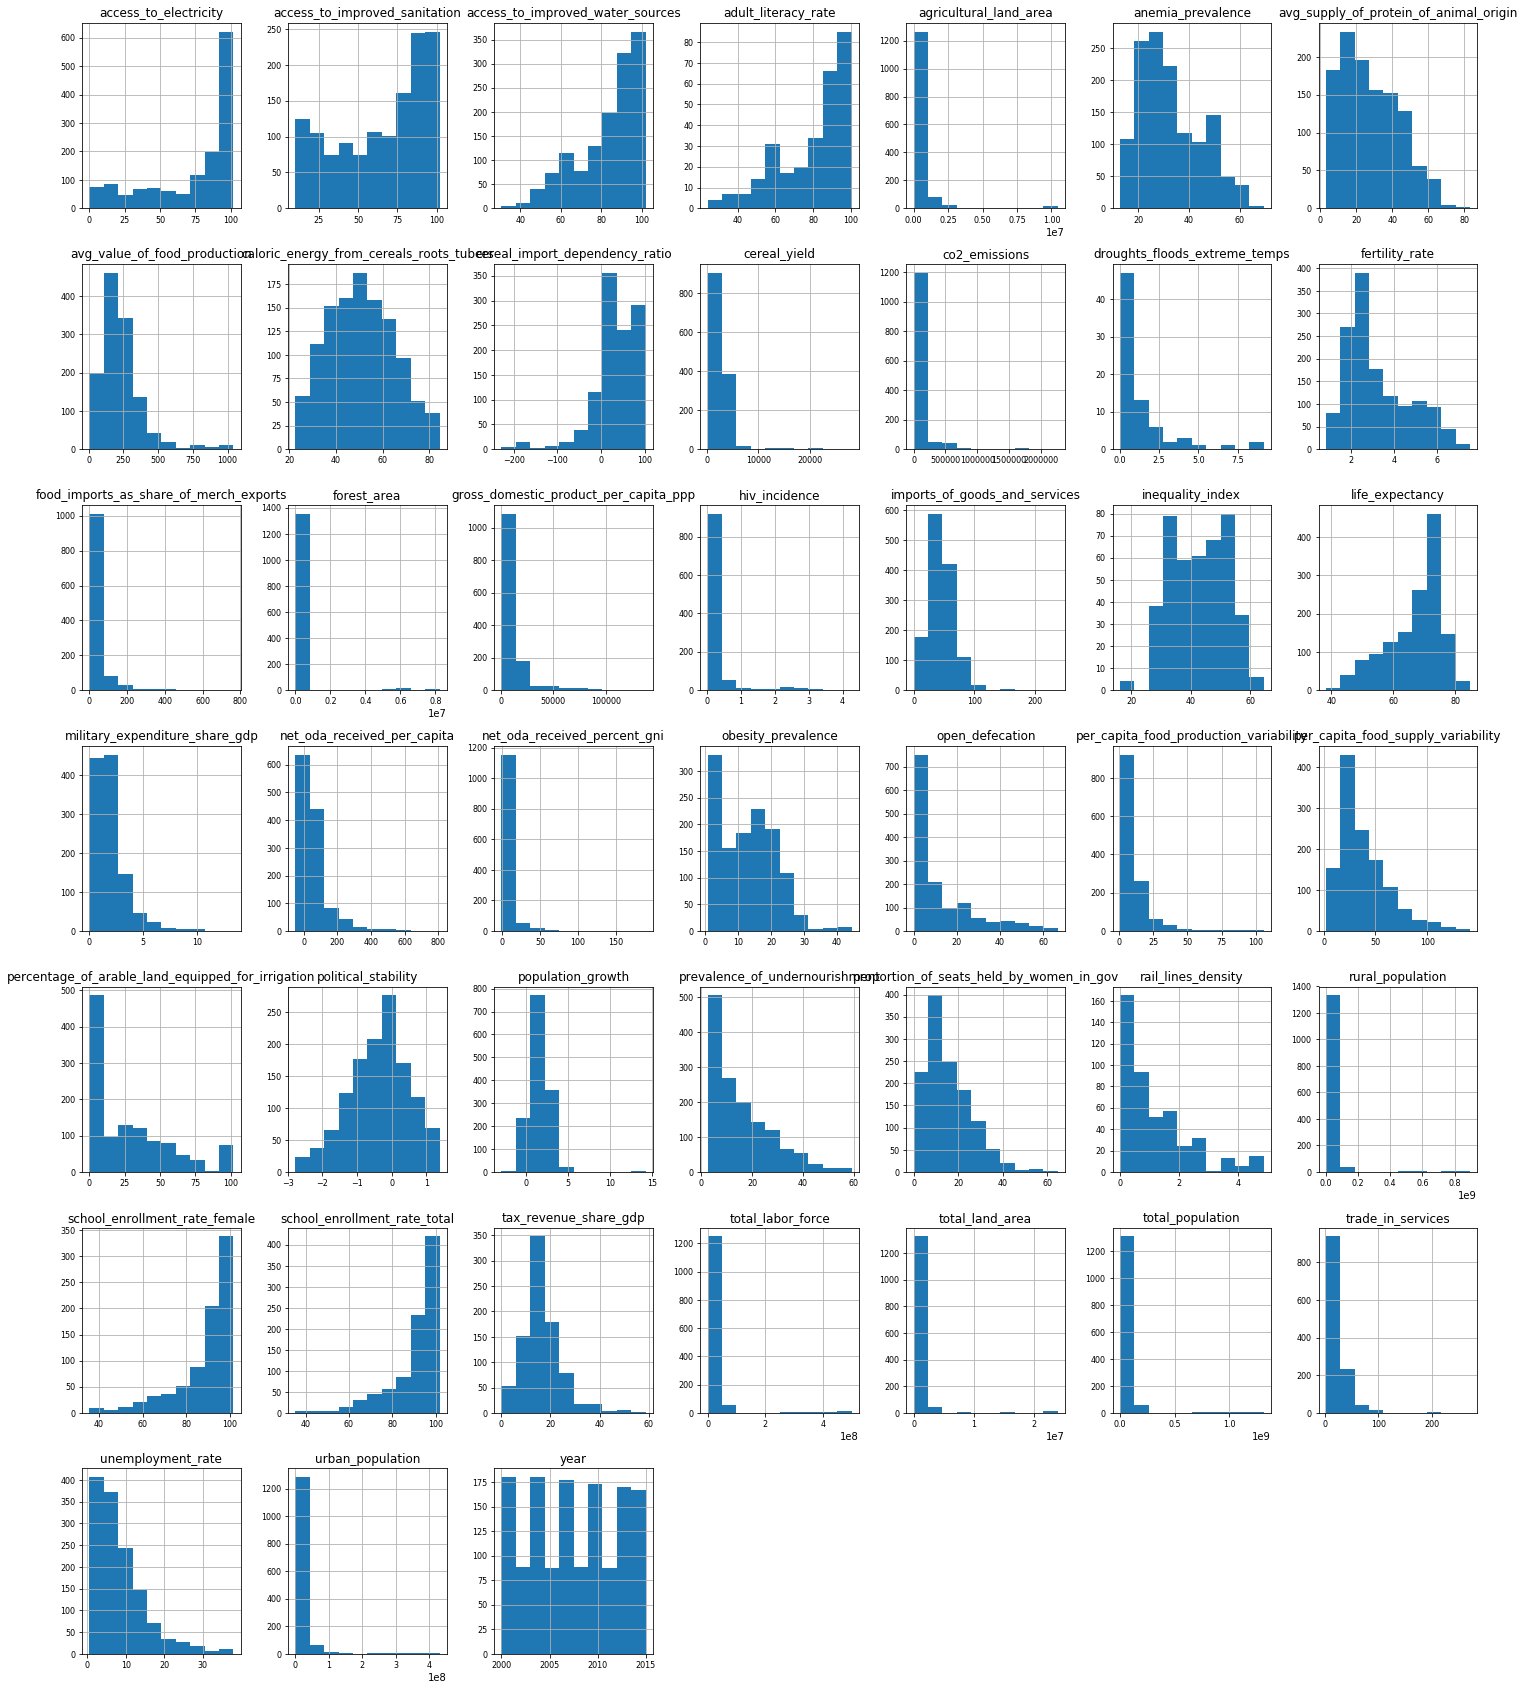

In [3]:
list(set(train_dat.dtypes.tolist()))
train_dat_num = train_dat.select_dtypes(include = ['float64', 'int64'])
train_dat_num.head()
train_dat_num.hist(figsize=(25, 30), bins=10, xlabelsize=8, ylabelsize=8)

Features such as unemployment_rate, per_capita_food_supply_variability follow a similar distribution as prevalence_of_undernoursihment.

####Correlation between numeric variabeles

Now we have a list of strongly correlated features but here we have not accounted for the effect of outliers. In the following steps we will remove the outliers and see which features have a good correlation without the outliers if any. For this we will have to plot the numerical features and see which ones have very few or explainable outliers. We can also see whether these features are linearly related to prevalence of underourishment.

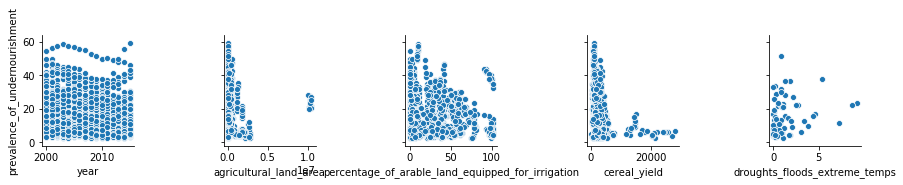

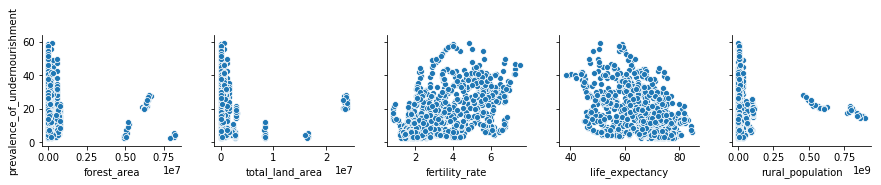

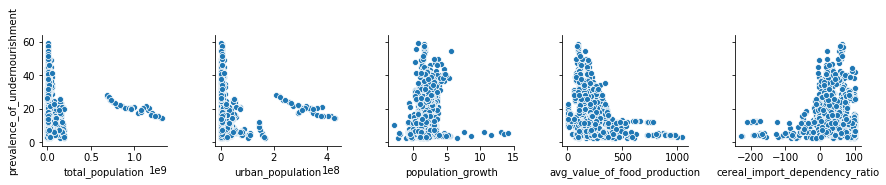

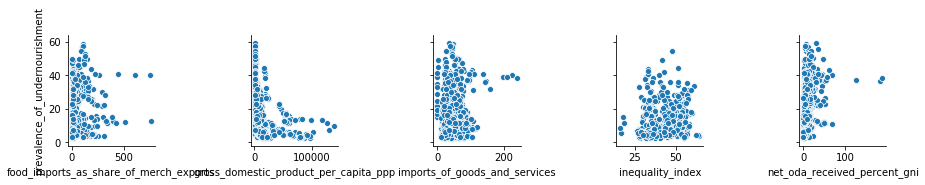

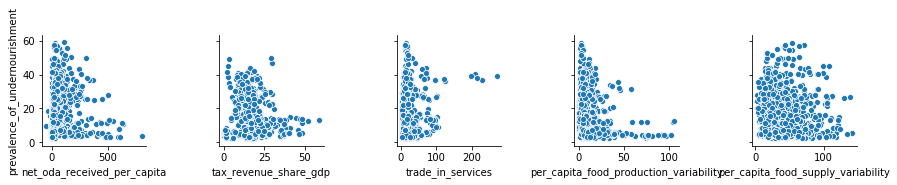

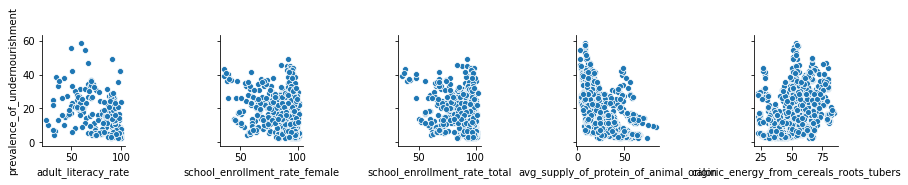

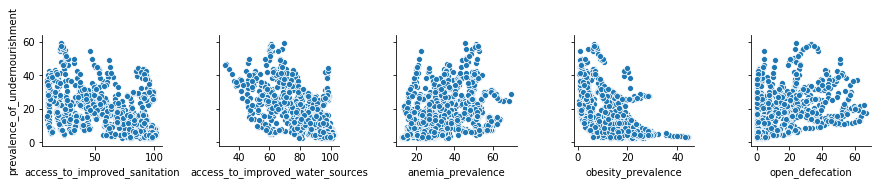

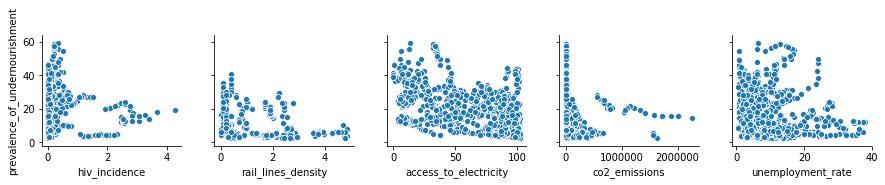

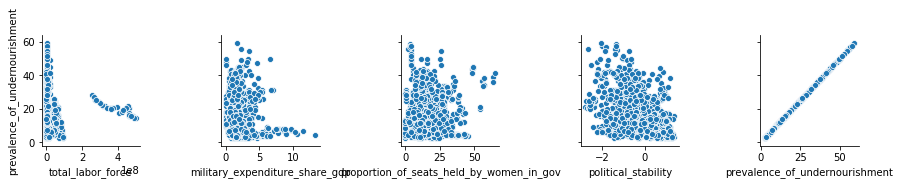

In [4]:
for i in range(0, len(train_dat_num.columns), 5):
    sns.pairplot(data=train_dat_num,x_vars=train_dat_num.columns[i:i+5],
                y_vars=['prevalence_of_undernourishment'])

As we can see RMSE for knn model with k = 1 is lowest of all the model 1.86, therefore we will use knn model with k = 1 to predict prevalence of undernourishment.

Clearly none of the variables seem to have linear relationship with prevalence of undernourishment. Now we will remove/fill in for the missing values and see the relation of each feature with prevalence of undernourishment. We will remove duplicate values as well

In [5]:
print(train_dat.shape)
train_dat=train_dat.drop_duplicates()
print(train_dat.shape) #No duplicates
mean_series = train_dat.mean(axis=0)
mean_list = mean_series.tolist()
for i in range(len(mean_list)):
    train_dat.iloc[:,i] = train_dat.iloc[:,i].fillna(mean_list[i])

(1401, 46)
(1401, 46)


####Finding correlations among all features again

In [6]:
train_dat_num_new = train_dat.select_dtypes(include = ['float64', 'int64'])
train_dat_corr_new = train_dat_num_new.corr()['prevalence_of_undernourishment'][:-1]
golden_features_list_new = train_dat_corr_new[abs(train_dat_corr_new) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with prevalence of undernourishment:\n{}".format(len(golden_features_list_new), golden_features_list_new))

There is 2 strongly correlated values with prevalence of undernourishment:
access_to_improved_sanitation   -0.562688
obesity_prevalence              -0.572823
Name: prevalence_of_undernourishment, dtype: float64


After filling the missing values we can see that only access_to_improved_sanitation and obesity_prevalence are strongly correlated with prevalence of undernourishment. Now we will examine correlation of each variable with other except prevalence of undernourishment as it has been done already.

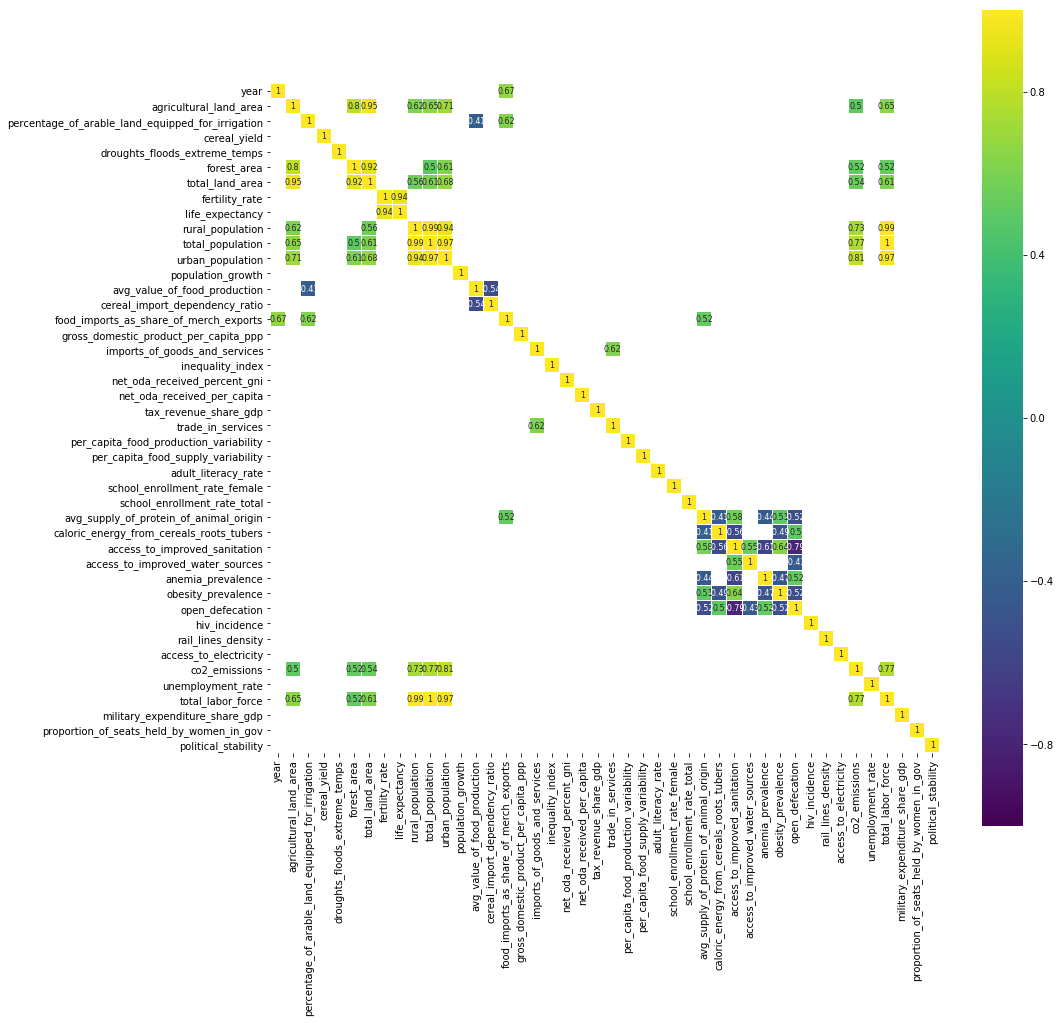

In [7]:
corr = train_dat_num_new.drop('prevalence_of_undernourishment', axis=1).corr() # We already examined undernourishment prevalence correlations
plt.figure(figsize=(15, 15))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

We can see that a lot of features are correlated with each other. Some of these features can be combined together to reduce the number of features, for example agricultural land area, forest area and total land area can be combined together. Now let's see the correlation of country with prevalence_of_undernourishment.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91]), <a list of 92 Text xticklabel objects>)

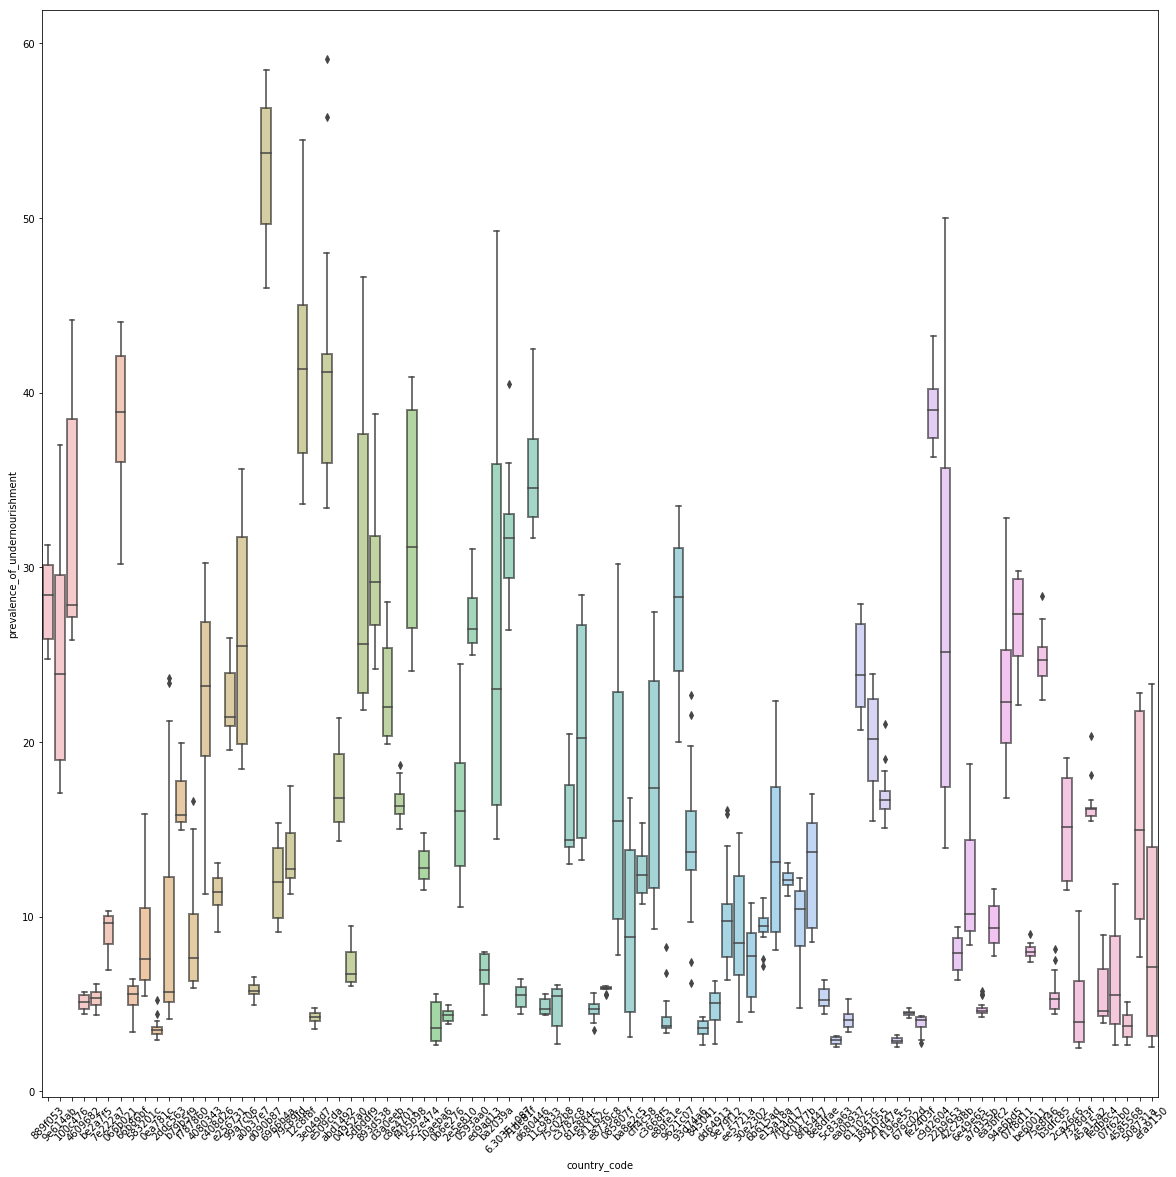

In [8]:
plt.figure(figsize = (20, 20))
ax = sns.boxplot(x='country_code', y='prevalence_of_undernourishment', data=train_dat)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

As we can see there are some countries which have undernourishment out of the box, these can be considered as outliers, if their absence doesn't affect the accuracy of our prediction model. Now we will see the distribution of country_codes.

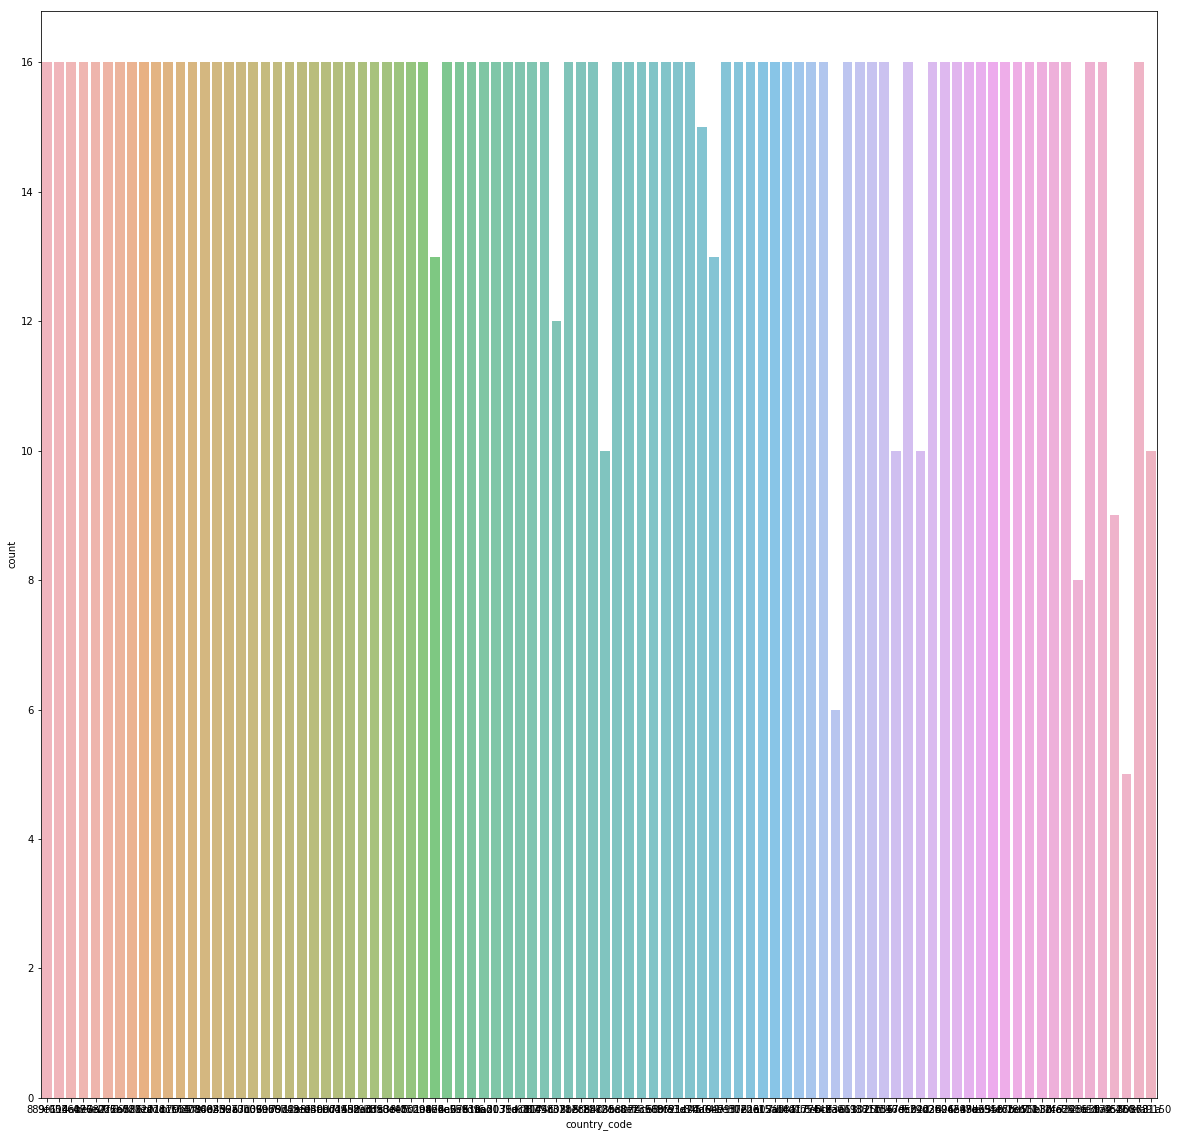

In [9]:
plt.figure(figsize = (20, 20))
sns.countplot(x='country_code', alpha=0.7, data=train_dat)
plt.show()

We can see that most of the countries have as high undernourishment prevalence as 16 while some countries have as low undernourishment prevalence as 5.

####Prection model

As we can see from the pairsplot most of the independent variables don't have a linear relationship with the dependent variable, therefore to verify our analysis of the pairplot we will create linear model and check it's fitness by plotting the residual plots.

In [15]:
#first we will divide the train_dat into train_val and train_labels
train_dat1 = train_dat.drop(['country_code'], axis = 1)
train_val = train_dat1.drop(['prevalence_of_undernourishment'], axis = 1)
train_lab = train_dat1.iloc[:,44]

#now we will split the train_val and train_lab into training and test sets
train_val_train, train_val_test, train_lab_train, train_lab_test = train_test_split(train_val, train_lab, test_size=0.3, 
                                                    random_state=1) 
#fitting the linear regression model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(train_val_train, train_lab_train) 
train_test_pred = lin_reg.predict(train_val_test)

#printing the regression coefficients
print('Coefficients: \n', lin_reg.coef_) 

Coefficients: 
 [-1.78458392e-01  7.38074181e-07 -2.21116004e-03  3.25442853e-04
  1.51178037e-06 -2.67841105e-07  3.16772406e-07  1.35004080e-01
 -9.60482993e-07  2.76342212e-08 -5.90163077e-08 -6.01040848e-08
 -1.35141322e-02 -1.72905187e-02 -1.60124438e-02  1.04320537e-03
 -1.59157682e-04 -2.79133750e-02  2.04931989e-02 -2.04707548e-03
  8.01438578e-03  1.18326591e-02  6.88347793e-02  2.84735667e-02
  2.46046158e-02  8.64826518e-03  1.14152961e-01  4.45406692e-04
 -2.26764307e-01 -3.06744425e-01 -8.84880888e-02 -1.66902874e-01
 -4.08797278e-02 -3.38362065e-01  7.43355748e-02 -2.08087730e+00
  1.94707751e-02  3.00104052e-05  3.97352122e-06  5.03091671e-07
  1.11188143e-07  1.95174185e-01  2.92706580e-03 -1.46718966e-01]


####Measuring the quality of the linear model

Variance score: 0.5904961652301075
RMSE is 7.206150118741986


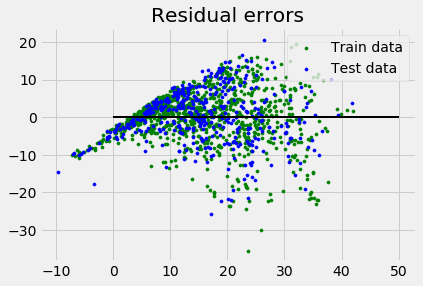

In [25]:
#measuring variance score: 1 means perfect prediction 
print('Variance score: {}'.format(lin_reg.score(train_val_test, train_lab_test)))

# plot for residual error
plt.style.use('fivethirtyeight')

## plotting residual errors in training data 
plt.scatter(lin_reg.predict(train_val_train), lin_reg.predict(train_val_train) - train_lab_train, 
            color = "green", s = 10, label = 'Train data')

## plotting residual error in test data
plt.scatter(lin_reg.predict(train_val_test), lin_reg.predict(train_val_test) - train_lab_test, 
            color = "blue", s = 10, label = 'Test data')

## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2) 
  
## plotting legend 
plt.legend(loc = 'upper right') 
  
## plot title 
plt.title("Residual errors")

## measuring root mean squared error
rmse = sqrt(mean_squared_error(train_lab_test, train_test_pred))
print('RMSE is ' + str(rmse))

There is no homoscedasticity in the residual plot, which means that there is a presence of non linear relationship between dependent and independent variable and as we can see the from the variance score only 54% of the variation of the given data is explained by the model. Furthermore, the root mean squared error is 7.21 which is very large as our dependent variable ranges from 1 to 100. Now we will go for a non_linear model as we saw that the relationship between dependent and independent variable if non-linear. We will fit a random forest model.

[0.9181364086472593, 0.9273841443314841, 0.9306524876967132, 0.9275490389858528, 0.9257539063232029, 0.9340235840810247, 0.9174360687805895, 0.9234672997831986, 0.9315459686911371, 0.933828137012149, 0.9323246461597324, 0.9298712792493699, 0.9286727122568148, 0.9322686493913312, 0.9295972399863206, 0.9288292981152955, 0.925944654595687, 0.9309640845325253, 0.9328717992323688]
[27.258372   33.636426   20.58927758 14.93155555 13.45868273 31.53267735
 23.53555102  7.15531788  7.63753712 31.79051207 11.75488756 12.48593567
 18.879952    6.0853206   4.79290686 13.1566941  15.39680306  6.53911237
  4.85331237 16.51270958  7.80107188  7.64221268  6.07300064 23.34834843
 21.61053578 27.52538397 21.53189274 27.0577633  39.71757922 16.29972155
  5.74014615 16.95170466 12.4275484  22.94010165 11.11382639  6.41656765
  3.71302648 12.21355049  4.82030195  7.46876532  4.73041782 38.71809886
 10.25217227 14.33749536  5.7411655  23.78360652  6.07948675  4.33656767
 30.03570886 11.20929727  8.85359078 

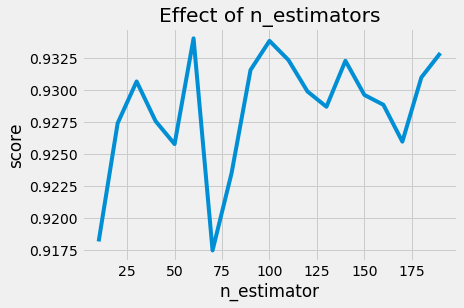

In [65]:
## establish random forest model
rf_mod = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
random.seed(10)
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rf_mod.set_params(n_estimators=n)
    rf_mod.fit(train_val_train, train_lab_train)
    scores.append(rf_mod.score(train_val_test, train_lab_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
print(scores)
train_test_pred_rf = rf_mod.predict(train_val_test)
print(train_test_pred_rf)

####Measuring quality of random forest model

Variance score: 0.9287725778763918


RMSE is 2.917607200262765


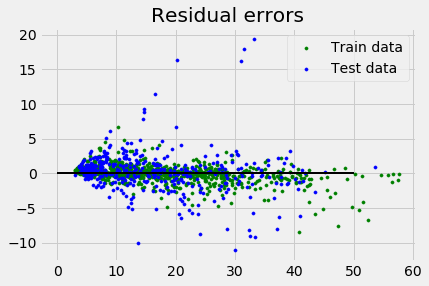

In [66]:
rf_mod.set_params(n_estimators = 65)
rf_mod.fit(train_val_train, train_lab_train)

#measuring variance score: 1 means perfect prediction 
print('Variance score: {}'.format(rf_mod.score(train_val_test, train_lab_test)))

# plot for residual error
plt.style.use('fivethirtyeight')

## plotting residual errors in training data 
plt.scatter(rf_mod.predict(train_val_train), rf_mod.predict(train_val_train) - train_lab_train, 
            color = "green", s = 10, label = 'Train data')

## plotting residual error in test data
plt.scatter(rf_mod.predict(train_val_test), rf_mod.predict(train_val_test) - train_lab_test, 
            color = "blue", s = 10, label = 'Test data')

## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2) 
  
## plotting legend 
plt.legend(loc = 'upper right') 
  
## plot title 
plt.title("Residual errors")

## measuring root mean squared error
rmse_rf = sqrt(mean_squared_error(train_lab_test, train_test_pred_rf))
print('RMSE is ' + str(rmse_rf))

Now as we can see from the residual plot, the residuals are clustered towards the zero error line and also the random forest model is able to explain about 93% of the variation in the dataset which is almost twice than the linear model. Root mean squared error the above model is approximately 3 which is half of the linear model for the dependent variable range of 0-100, which means the random forest model is performing two times better than the linear model. We will create a knn model and compare it's quality with linear regression and random forest models.

RMSE value for k=  1 is: 1.8649943522572676
RMSE value for k=  2 is: 2.474587785541945
RMSE value for k=  3 is: 3.0412139125363145
RMSE value for k=  4 is: 3.5231197891282524
RMSE value for k=  5 is: 3.9771267512547253
RMSE value for k=  6 is: 4.481002896992738
RMSE value for k=  7 is: 4.912661379223013
RMSE value for k=  8 is: 5.351800176564821


RMSE value for k=  9 is: 5.612520560556327
RMSE value for k=  10 is: 5.874375179966524
RMSE value for k=  11 is: 6.087153290655269
RMSE value for k=  12 is: 6.240516844084907
RMSE value for k=  13 is: 6.476664772594902
RMSE value for k=  14 is: 6.683481850135627
RMSE value for k=  15 is: 6.869684970627974
RMSE value for k=  16 is: 7.03323036081916


RMSE value for k=  17 is: 7.201648487923371
RMSE value for k=  18 is: 7.30088377612445
RMSE value for k=  19 is: 7.438915038637471
RMSE value for k=  20 is: 7.535827951387129


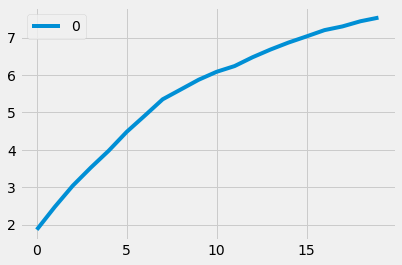

In [67]:
rmse_knn = [] #to store rmse values for different k
random.seed(10)
for K in range(20):
    K = K+1
    knn_mod = neighbors.KNeighborsRegressor(n_neighbors = K)
    knn_mod.fit(train_val_train, train_lab_train)  #fit the model
    knn_pred=knn_mod.predict(train_val_test) #make prediction on test set
    error = sqrt(mean_squared_error(train_lab_test,knn_pred)) #calculate rmse
    rmse_knn.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

#plotting the rmse values against k values
curve = pd.DataFrame(rmse_knn) #elbow curve 
curve.plot()

As we can see RMSE for knn model with k = 1 is lowest of all the model 1.86, therefore we will use knn model with k = 1 to predict prevalence of undernourishment.

In [73]:
## predicting the prevalence of undernourishment for the test data
test_var = pd.read_csv('C:/Users/shrut/OneDrive/Documents/Capstone Project/test_values_K7FqC54.csv')
test_var = test_var.drop(['country_code','row_id'], axis = 1)
## manipulating the data to remove duplicates and fill in for the missing values
print(test_var.shape)
test_var=test_var.drop_duplicates()
print(test_var.shape) #No duplicates
mean_series_test = test_var.mean(axis=0)
mean_list_test = mean_series_test.tolist()
for i in range(len(mean_list_test)):
    test_var.iloc[:,i] = test_var.iloc[:,i].fillna(mean_list_test[i])

## Predictions
knn_mod_1 = neighbors.KNeighborsRegressor(n_neighbors = 1)
knn_mod_1.fit(train_val_train, train_lab_train)  #fit the model
knn_pred_1=knn_mod_1.predict(train_val_test) #make prediction on test set
error = sqrt(mean_squared_error(train_lab_test,knn_pred_1)) #calculate rmse
print(error)
print('Variance score: {}'.format(knn_mod_1.score(train_val_test, train_lab_test)))
test_var_pred_1 = knn_mod_1.predict(test_var)

(616, 44)
(616, 44)
1.8649943522572676
Variance score: 0.9725712254547413


The knn model with k = 1 gives RMSE of 1.86 and variance of 97%, which makes it the best predictive model among linear regression, random forest and knn.

#### Importing predicted values as a csv file

In [72]:
csvfile = "C:/Users/shrut/OneDrive/Documents/Capstone Project/Test Predictions.csv"

with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in test_var_pred_1:
        writer.writerow([val]) 